# Install Transformers Library

In [ ]:
!pip install transformers

In [ ]:
# importing necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import re
# For handling string
import string
# For performing mathematical operations
import math
import spacy
# For visualizations
import matplotlib.pyplot as plt
# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
stopwords = list(STOP_WORDS)

from heapq import nlargest
punctuation = punctuation + '\n'

# specify GPU
device = torch.device("cuda")

# Load Dataset

In [ ]:
df = pd.read_csv("Symptom2Disease.csv")
df = df.drop(columns=['Unnamed: 0'])
df.head()

label                                               text
0  Psoriasis  I have been experiencing a skin rash on my arm...
1  Psoriasis  My skin has been peeling, especially on my kne...
2  Psoriasis  I have been experiencing joint pain in my fing...
3  Psoriasis  There is a silver like dusting on my skin, esp...
4  Psoriasis  My nails have small dents or pits in them, and...

In [ ]:
df.shape

(1200, 2)

In [ ]:
# convert labels into int values
df['label_int'] = pd.Categorical(df['label']).codes

In [ ]:
# check class distribution
df['label_int'].value_counts(normalize = True)

15    0.041667
17    0.041667
22    0.041667
20    0.041667
21    0.041667
18    0.041667
23    0.041667
12    0.041667
11    0.041667
3     0.041667
13    0.041667
9     0.041667
2     0.041667
0     0.041667
1     0.041667
7     0.041667
14    0.041667
5     0.041667
8     0.041667
6     0.041667
10    0.041667
4     0.041667
16    0.041667
19    0.041667
Name: label_int, dtype: float64

In [ ]:
# check class distribution
df['label'].value_counts(normalize = True)

Psoriasis                          0.041667
Varicose Veins                     0.041667
peptic ulcer disease               0.041667
drug reaction                      0.041667
gastroesophageal reflux disease    0.041667
allergy                            0.041667
urinary tract infection            0.041667
Malaria                            0.041667
Jaundice                           0.041667
Cervical spondylosis               0.041667
Migraine                           0.041667
Hypertension                       0.041667
Bronchial Asthma                   0.041667
Acne                               0.041667
Arthritis                          0.041667
Dimorphic Hemorrhoids              0.041667
Pneumonia                          0.041667
Common Cold                        0.041667
Fungal infection                   0.041667
Dengue                             0.041667
Impetigo                           0.041667
Chicken pox                        0.041667
Typhoid                         

In [ ]:
# getting all codes
codes = df['label_int']

# Get the original labels from the codes
original_labels = df['label'].astype('category').cat.categories

### Exploratory data analysis

In [ ]:
original_text = []
for index, row in df.iterrows():
    original_text.append(row['text'])

df = df.assign(Original_text = original_text)

df.head()

label                                               text  label_int  \
0  Psoriasis  I have been experiencing a skin rash on my arm...         15   
1  Psoriasis  My skin has been peeling, especially on my kne...         15   
2  Psoriasis  I have been experiencing joint pain in my fing...         15   
3  Psoriasis  There is a silver like dusting on my skin, esp...         15   
4  Psoriasis  My nails have small dents or pits in them, and...         15   

                                       Original_text  
0  I have been experiencing a skin rash on my arm...  
1  My skin has been peeling, especially on my kne...  
2  I have been experiencing joint pain in my fing...  
3  There is a silver like dusting on my skin, esp...  
4  My nails have small dents or pits in them, and...

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          1200 non-null   object
 1   text           1200 non-null   object
 2   label_int      1200 non-null   int8  
 3   Original_text  1200 non-null   object
dtypes: int8(1), object(3)
memory usage: 29.4+ KB


In [ ]:
df.nunique()

label              24
text             1153
label_int          24
Original_text    1153
dtype: int64

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153 entries, 0 to 1199
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          1153 non-null   object
 1   text           1153 non-null   object
 2   label_int      1153 non-null   int8  
 3   Original_text  1153 non-null   object
dtypes: int8(1), object(3)
memory usage: 37.2+ KB


In [ ]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not",
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

In [ ]:
# Expanding Contractions in the reviews
df['text']=df['text'].apply(lambda x:expand_contractions(x))

# change all text to lower case
df['text']=df['text'].apply(lambda x: x.lower())

# remove punctuations
df['text']=df['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

# Lemmatization with stopwords removal
df['text']=df['text'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

df.head()

label                                               text  label_int  \
0  Psoriasis  experience skin rash arm leg torso past week r...         15   
1  Psoriasis  skin peel especially knee elbow scalp peeling ...         15   
2  Psoriasis  experience joint pain finger wrist knee pain a...         15   
3  Psoriasis  silver like dust skin especially low scalp dus...         15   
4  Psoriasis  nail small dent pit feel inflammatory tender t...         15   

                                       Original_text  
0  I have been experiencing a skin rash on my arm...  
1  My skin has been peeling, especially on my kne...  
2  I have been experiencing joint pain in my fing...  
3  There is a silver like dusting on my skin, esp...  
4  My nails have small dents or pits in them, and...

In [ ]:
# Creating Document Term Matrix
df_grouped=df[['label','text']].groupby(by='label').agg(lambda x:' '.join(x))
df_grouped.head()


from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped['text'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names_out())
df_dtm.index=df_grouped.index
df_dtm.head(10)

abdoman  abdomen  abdominal  ability  able  abound  \
label                                                                       
Acne                         0        0          0        0     0       2   
Arthritis                    0        0          0        0     0       0   
Bronchial Asthma             0        0          0        0     3       0   
Cervical spondylosis         0        0          0        0     0       0   
Chicken pox                  0        0          0        0     0       0   
Common Cold                  0        0          0        0     0       0   
Dengue                       0        0          0        0     1       0   
Dimorphic Hemorrhoids        0        0          0        0     1       0   
Fungal infection             0        0          0        0     0       0   
Hypertension                 0        0          0        5     0       0   

                       abrupt  absolutely  aburning  accomapanie  ...  worsen  \
label                                                             ...           
Acne                        0           1         0            0  ...       0   
Arthritis                   0           0         0            0  ...       0   
Bronchial Asthma            0           0         0            0  ...       0   
Cervical spondylosis        0           0         0            0  ...       0   
Chicken pox                 0           0         0            0  ...       0   
Common Cold                 0           0         0            0  ...       0   
Dengue                      0           0         0            1  ...       0   
Dimorphic Hemorrhoids       0           0         0            0  ...       0   
Fungal infection            0           0         0            0  ...       0   
Hypertension                0           0         0            0  ...       0   

                       wound  wrist  wrong  yeast  yellow  yellowish  \
label                                                                  
Acne                       0      0      0      0       0          0   
Arthritis                  0      0      0      0       0          0   
Bronchial Asthma           0      0      0      0       0          0   
Cervical spondylosis       0      0      0      0       0          0   
Chicken pox                0      0      4      0       0          0   
Common Cold                0      0      0      0       0          0   
Dengue                     0      0      1      0       0          0   
Dimorphic Hemorrhoids      0      0      0      0       0          0   
Fungal infection           0      0      0      0       0          0   
Hypertension               0      0      0      0       0          0   

                       yellowrust  yesterday  zone  
label                                               
Acne                            0          2     0  
Arthritis                       0          0     0  
Bronchial Asthma                0          0     0  
Cervical spondylosis            0          0     0  
Chicken pox                     0          1     0  
Common Cold                     0          0     0  
Dengue                          0          0     0  
Dimorphic Hemorrhoids           0          0     0  
Fungal infection                0          0     0  
Hypertension                    0          0     1  

[10 rows x 1168 columns]

In [ ]:
# Transposing document term matrix
df_dtm=df_dtm.transpose()
df_dtm.head(5)

label      Acne  Arthritis  Bronchial Asthma  Cervical spondylosis  \
abdoman       0          0                 0                     0   
abdomen       0          0                 0                     0   
abdominal     0          0                 0                     0   
ability       0          0                 0                     0   
able          0          0                 3                     0   

label      Chicken pox  Common Cold  Dengue  Dimorphic Hemorrhoids  \
abdoman              0            0       0                      0   
abdomen              0            0       0                      0   
abdominal            0            0       0                      0   
ability              0            0       0                      0   
able                 0            0       1                      1   

label      Fungal infection  Hypertension  ...  Pneumonia  Psoriasis  Typhoid  \
abdoman                   0             0  ...          0          0        0   
abdomen                   0             0  ...          0          1        0   
abdominal                 0             0  ...          0          0       12   
ability                   0             5  ...          0          0        0   
able                      0             0  ...          0          0        1   

label      Varicose Veins  allergy  diabetes  drug reaction  \
abdoman                 0        0         0              0   
abdomen                 0        0         0              0   
abdominal               0        0         0              0   
ability                 0        2         1              1   
able                    0        0         0              1   

label      gastroesophageal reflux disease  peptic ulcer disease  \
abdoman                                  4                     3   
abdomen                                  2                     6   
abdominal                                1                     3   
ability                                  0                     0   
able                                     0                     0   

label      urinary tract infection  
abdoman                          2  
abdomen                          2  
abdominal                        1  
ability                          0  
able                             2  

[5 rows x 24 columns]

In [ ]:
# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=650, height=400, max_words=150, background_color="white").generate_from_frequencies(data)
  return wc

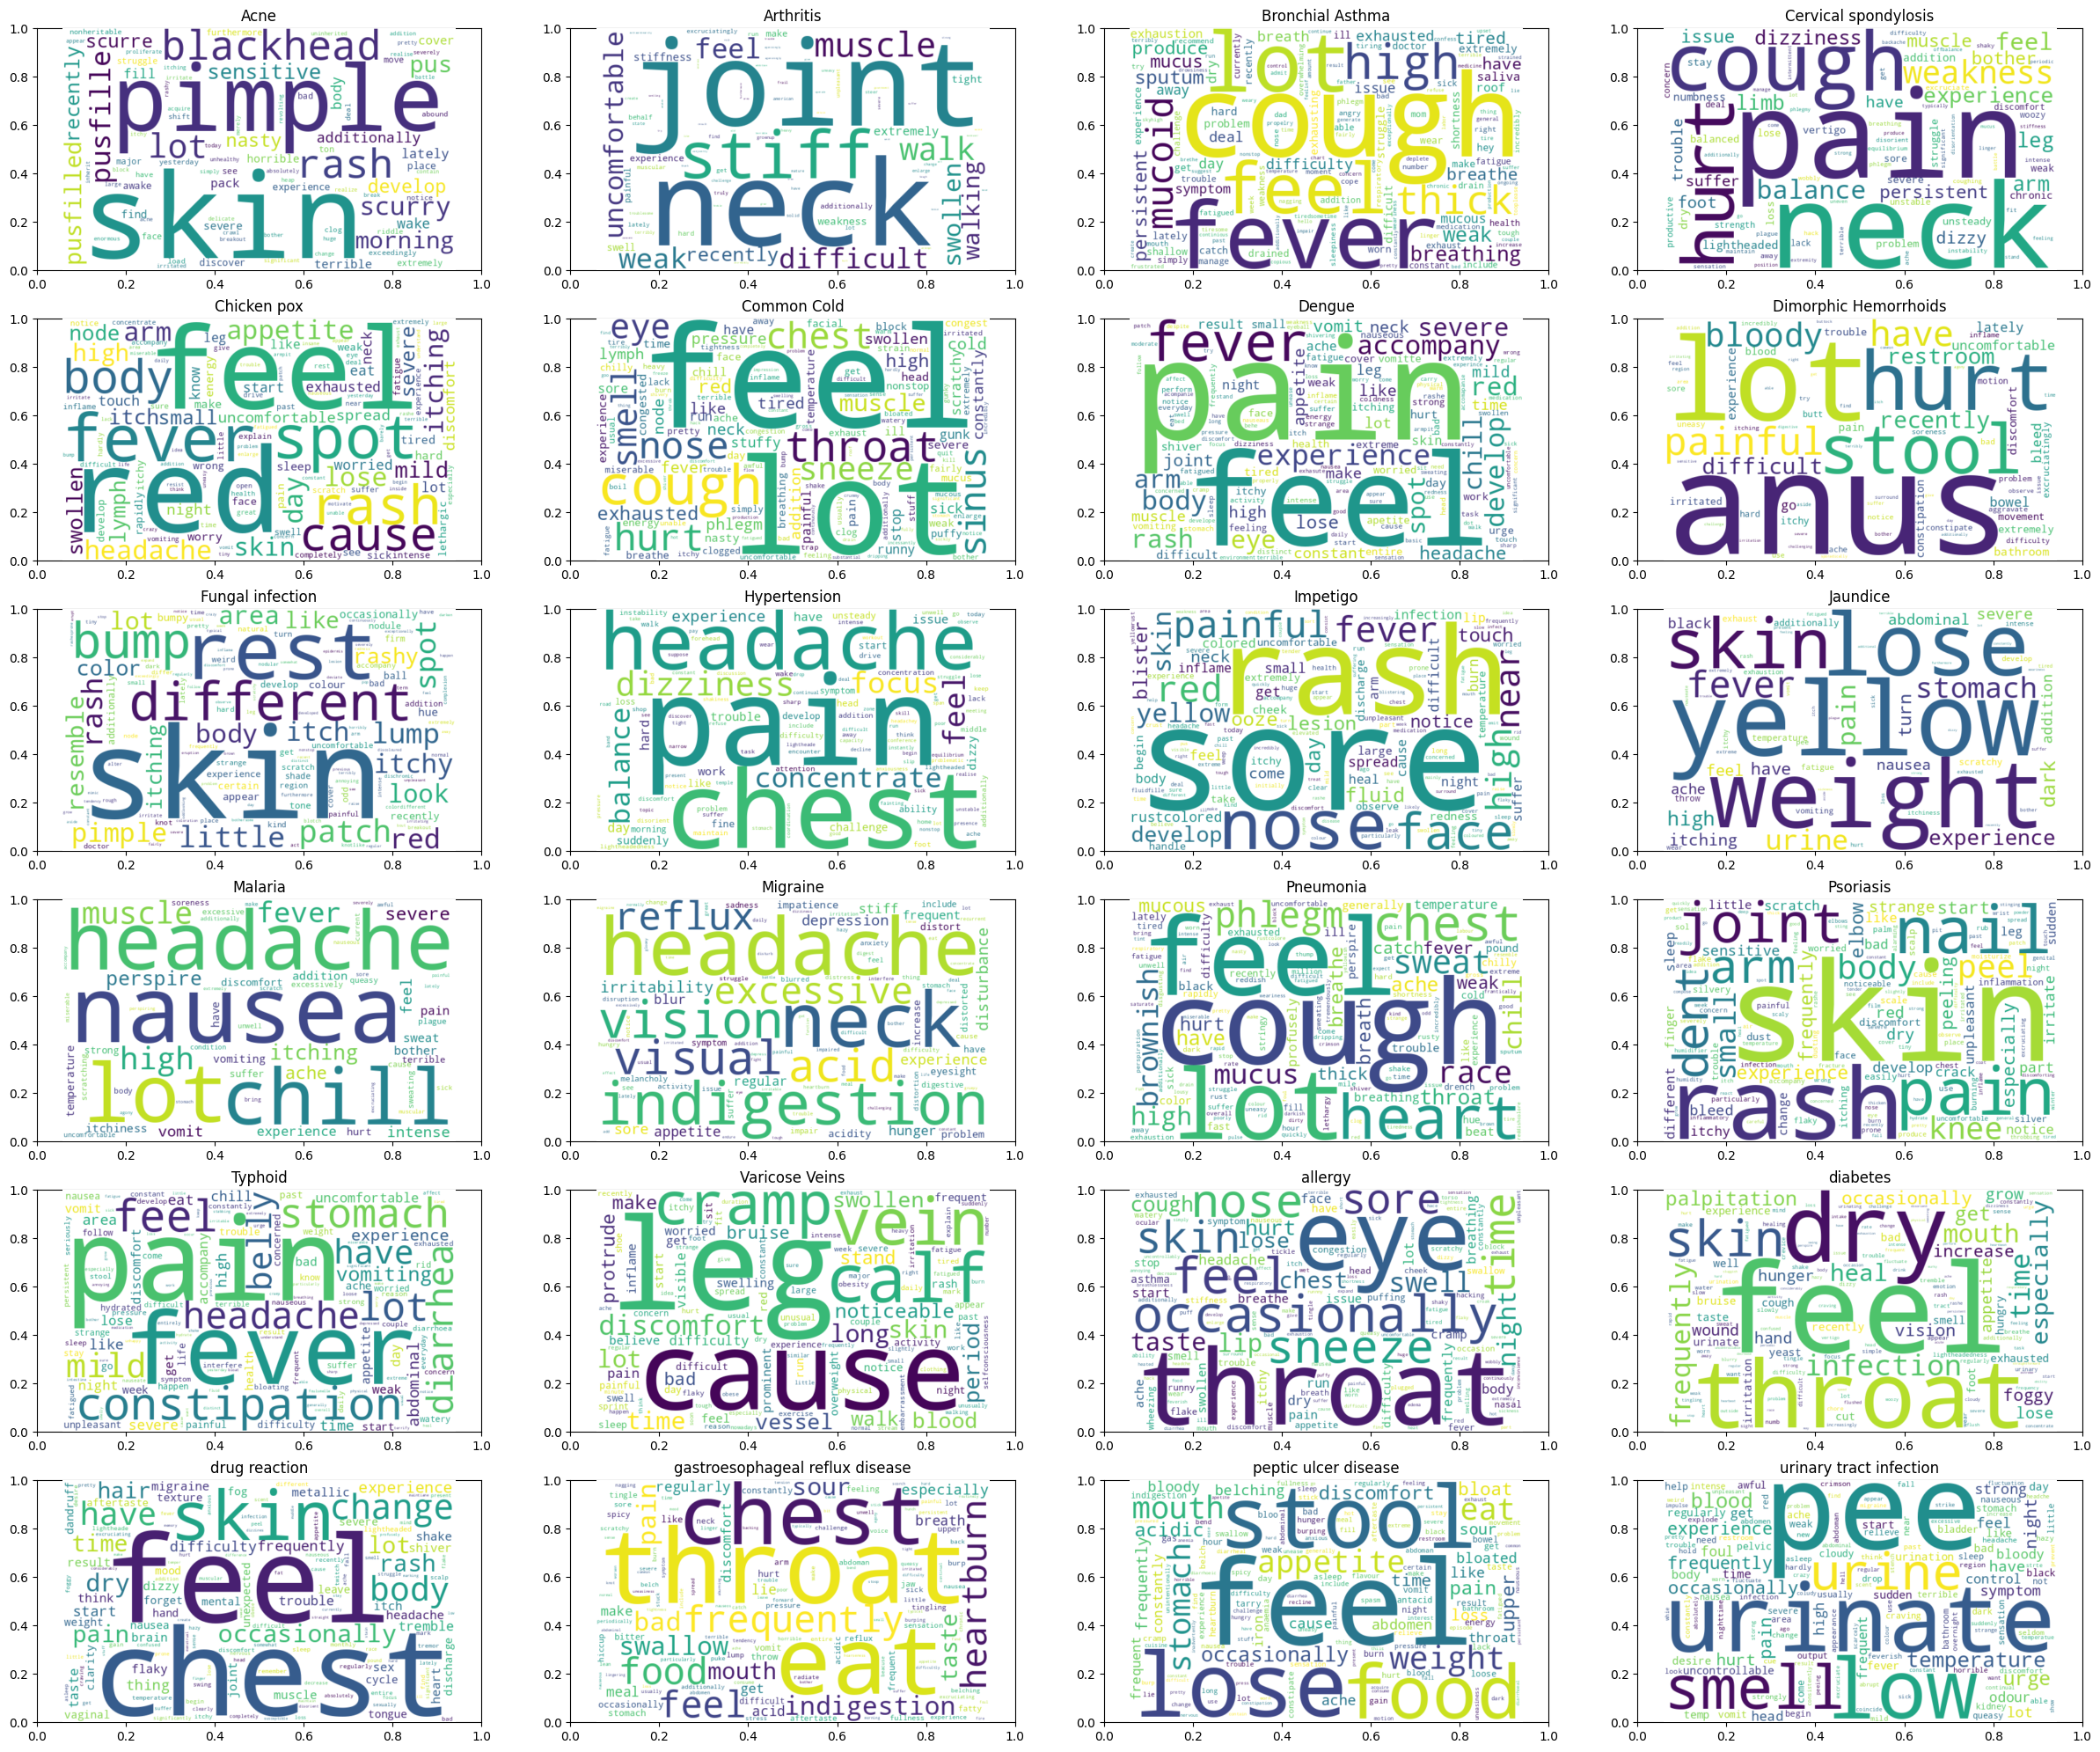

In [ ]:
# Plotting word cloud for each label
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(30, 25))
for index,label in enumerate(df_dtm.columns):
  ax = fig.add_subplot(6,4, index +1)
  wordcloud = generate_wordcloud(df_dtm[label].sort_values(ascending=False),label)
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis('off')
  ax.set_title(label)

<Axes: >

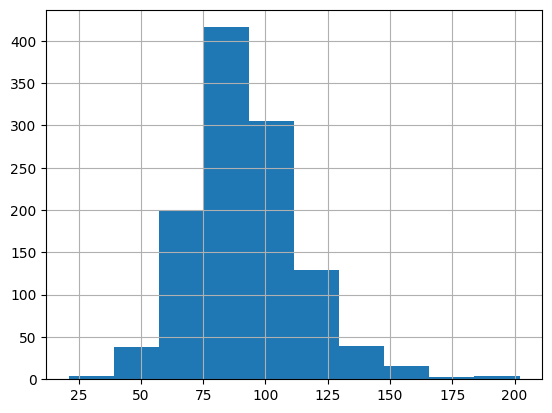

In [ ]:
df['text'].str.len().hist()

# Split train dataset into train, validation and test sets

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label_int'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label_int'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

<Axes: >

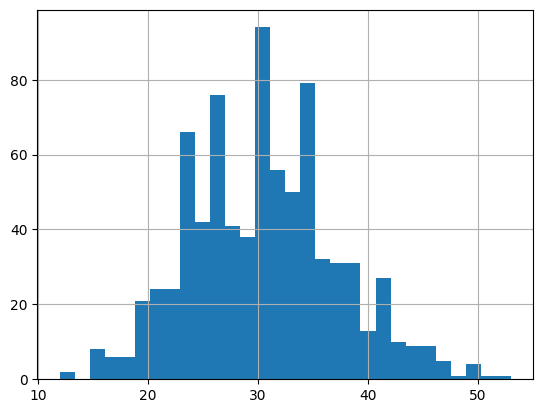

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 60

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 20

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,2056)

      # dense layer 2
      #self.fc3 = nn.Linear(512,256)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(2056,24)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      #x = self.fc3(x)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
#model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)  #  lr = 1e-3

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes  = np.unique(train_labels), y = train_labels)

print(class_wts)

[1.05078125 1.05078125 0.98897059 0.98897059 0.98897059 0.98897059
 0.96071429 1.15948276 0.96071429 0.96071429 0.96071429 1.24537037
 1.08467742 1.01893939 1.01893939 0.96071429 0.96071429 0.96071429
 0.96071429 0.96071429 0.96071429 0.98897059 0.96071429 0.96071429]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
#weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    #batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    #batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
#load weights of best model
#path = 'saved_weights.pt'
#model.load_state_dict(torch.load(path))

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

epochs = 50

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 50

Evaluating...

Training Loss: 3.319
Validation Loss: 3.167

 Epoch 2 / 50

Evaluating...

Training Loss: 3.168
Validation Loss: 3.131

 Epoch 3 / 50

Evaluating...

Training Loss: 3.117
Validation Loss: 3.095

 Epoch 4 / 50

Evaluating...

Training Loss: 3.084
Validation Loss: 3.016

 Epoch 5 / 50

Evaluating...

Training Loss: 3.031
Validation Loss: 2.960

 Epoch 6 / 50

Evaluating...

Training Loss: 2.976
Validation Loss: 2.895

 Epoch 7 / 50

Evaluating...

Training Loss: 2.912
Validation Loss: 2.820

 Epoch 8 / 50

Evaluating...

Training Loss: 2.860
Validation Loss: 2.854

 Epoch 9 / 50

Evaluating...

Training Loss: 2.804
Validation Loss: 2.714

 Epoch 10 / 50

Evaluating...

Training Loss: 2.725
Validation Loss: 2.619

 Epoch 11 / 50

Evaluating...

Training Loss: 2.687
Validation Loss: 2.592

 Epoch 12 / 50

Evaluating...

Training Loss: 2.637
Validation Loss: 2.551

 Epoch 13 / 50

Evaluating...

Training Loss: 2.590
Validation Loss: 2.459

 Epoch 14 / 50

Eval

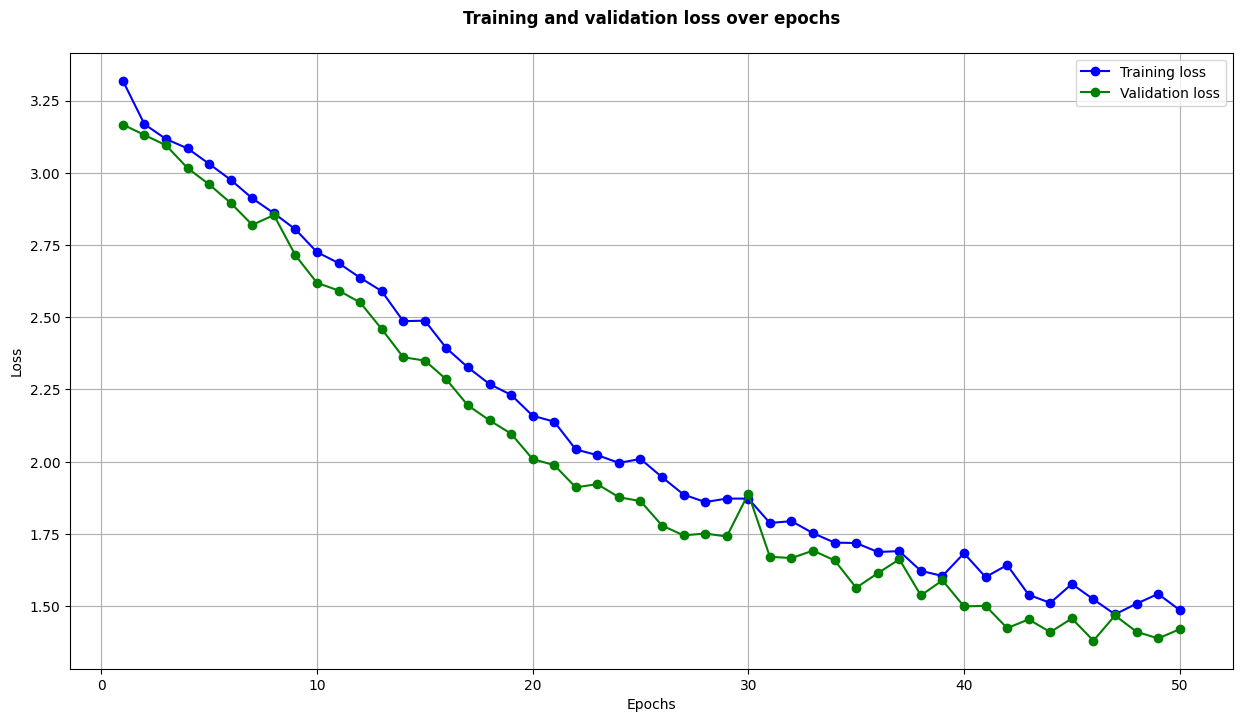

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Training and validation loss Over Epochs
def plot_train_valid_loss(training_loss, validation_loss, c = 'b', c2 = 'g'):
    epochs = range(1, len(training_loss) + 1)

    plt.figure(figsize=(15, 8))
    plt.plot(epochs, training_loss, marker='o', linestyle='-', color =  c, label = 'Training loss')
    plt.plot(epochs, validation_loss, marker='o', linestyle='-', color =  c2, label = 'Validation loss')
    plt.title('Training and validation loss over epochs\n', fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
plot_train_valid_loss(train_losses, valid_losses)
print("\n\n")

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  # preds = model(test_seq.to(device), test_mask.to(device))
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.88      1.00      0.93         7
           2       0.83      0.71      0.77         7
           3       1.00      0.57      0.73         7
           4       0.67      0.50      0.57         8
           5       0.56      0.71      0.63         7
           6       0.67      0.25      0.36         8
           7       0.67      1.00      0.80         6
           8       0.54      0.88      0.67         8
           9       1.00      0.75      0.86         8
          10       0.28      0.71      0.40         7
          11       0.21      0.60      0.32         5
          12       0.50      0.86      0.63         7
          13       0.83      0.71      0.77         7
          14       0.67      0.57      0.62         7
          15       0.00      0.00      0.00         8
          16       0.25      0.14      0.18         7
          17       1.00    

Text(0.5, 1.0, 'Confusion Matrix')

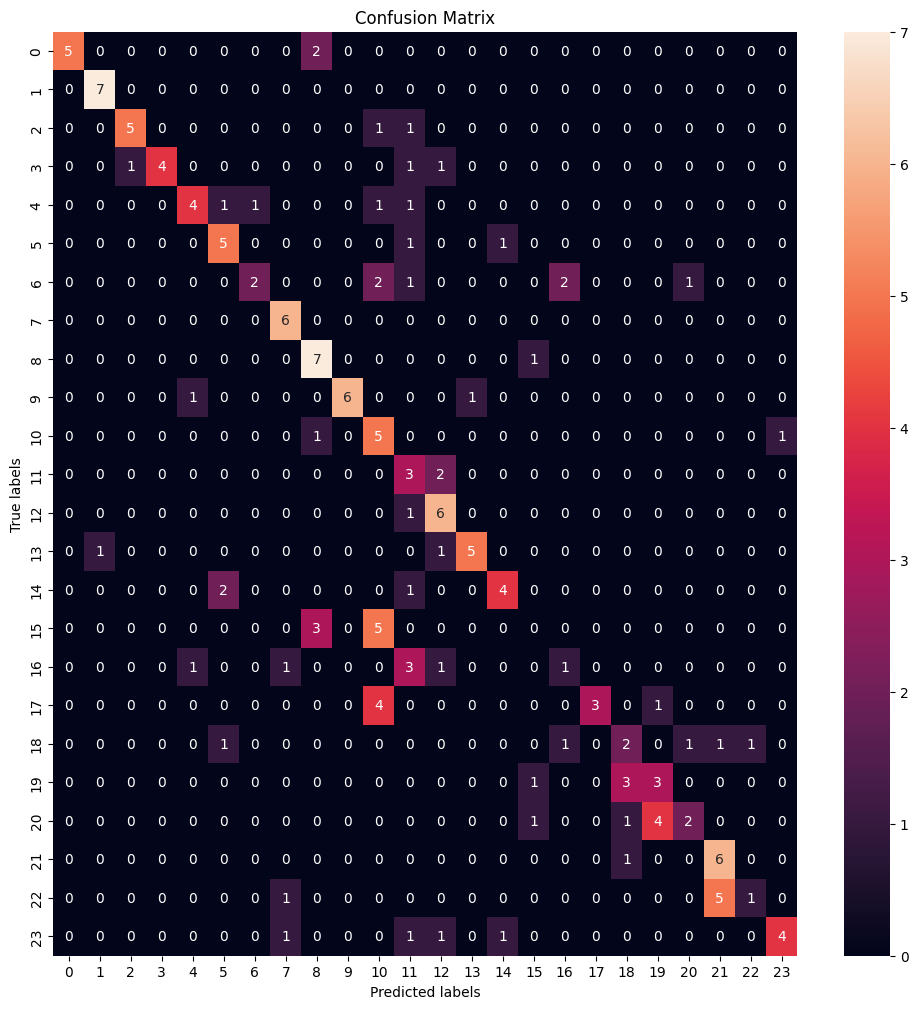

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

cm = confusion_matrix(test_y, preds)

plt.subplots(figsize=(12,12))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [ ]:
# testing data using the csv data (original data) without any preprocessing
# rows randomly selected

sent1 = 'My fingers and soles have pretty thick skin that is cracked severely. These fractures hurt and bleed frequently. The fractures are itchy and covered with scales.' # Psoriasis
sent2 = 'I am feeling really sick. I have a high fever and headache. I noticed rashes on my arms and face. I am extremely worried about this. Today, I observed red sores near my nose.' # Impetigo
sent3 = 'I have a rash on my legs that is causing a lot of discomforts. It seems there is a cramp and I can see prominent veins on the calf. Also, I have been feeling very tired and fatigued in the past couple of days.' # Varicose Veins
text = [sent1, sent2, sent3]

sent_ids = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

text_seq = torch.tensor(sent_ids['input_ids'])
text_mask = torch.tensor(sent_ids['attention_mask'])


# get predictions for test data
with torch.no_grad():
  preds = model(text_seq, text_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(preds)

print(original_labels[preds])

[ 8 10 10]
Index(['Fungal infection', 'Impetigo', 'Impetigo'], dtype='object')


In [ ]:
# for checking the sentence labels
df.loc[df['Original_text'] == sent2]

label                                               text  label_int  \
225  Impetigo  feel sick high fever headache notice rash arm ...         10   

                                         Original_text  
225  I am feeling really sick. I have a high fever ...

In [ ]:
# getting prediction on random text
# modification has been done on the original text and getting the prediction after modification
sent1 = 'These fractures hurt and bleed frequently. The fractures are itchy and covered with scales. My fingers and soles have pretty thick skin that is cracked severely' # Psoriasis
sent2 = 'I am feeling sick. I have a fever and headache. I noticed rashes on my arms and face. I am worried about this. I observed red sores near my nose.' # Impetigo
sent3 = 'I have a rash on my legs that is causing discomforts. There is a cramp and I can see prominent veins on the calf. I have been feeling very tired and fatigued in the past couple of days.' # Varicose Veins

text = [sent1, sent2, sent3]


# Expanding Contractions in the reviews
text = list(map(lambda x: expand_contractions(x), text))

# change all text to lower case
text = list(map(lambda x: x.lower(), text))

# remove punctuations
text = list(map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x), text))

# Lemmatization with stopwords removal
text = list(map(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]), text))


In [ ]:
sent_ids = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

text_seq = torch.tensor(sent_ids['input_ids'])
text_mask = torch.tensor(sent_ids['attention_mask'])


# get predictions for test data
with torch.no_grad():
  preds = model(text_seq, text_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(preds)

print(original_labels[preds])

[21 22 13]
Index(['gastroesophageal reflux disease', 'peptic ulcer disease', 'Migraine'], dtype='object')


## Get prediction after getting summary data

In [ ]:
df.head()

label                                               text  label_int  \
0  Psoriasis  experience skin rash arm leg torso past week r...         15   
1  Psoriasis  skin peel especially knee elbow scalp peeling ...         15   
2  Psoriasis  experience joint pain finger wrist knee pain a...         15   
3  Psoriasis  silver like dust skin especially low scalp dus...         15   
4  Psoriasis  nail small dent pit feel inflammatory tender t...         15   

                                       Original_text  
0  I have been experiencing a skin rash on my arm...  
1  My skin has been peeling, especially on my kne...  
2  I have been experiencing joint pain in my fing...  
3  There is a silver like dusting on my skin, esp...  
4  My nails have small dents or pits in them, and...

##**Summarization using Spacy**:

In [ ]:
nlp = spacy.load('en_core_web_sm')

def get_summary_spacy(text):
    # Word Tokenization
    doc = nlp(text)

    word_frequencies = {}
    for word in doc:
      if word.text.lower() not in stopwords:
        if word.text.lower() not in punctuation:
          if word.text not in word_frequencies.keys():
            word_frequencies[word.text] = 1
          else:
            word_frequencies[word.text] += 1

    max_frequency = max(word_frequencies.values())


    for word in word_frequencies.keys():
      word_frequencies[word] = word_frequencies[word]/max_frequency


    # Sentence tokenization:
    sentence_tokens = [sent for sent in doc.sents]

    # Word frequency table:
    sentence_scores = {}
    for sent in sentence_tokens:
      for word in sent:
        if word.text.lower() in word_frequencies.keys():
          if sent not in sentence_scores.keys():
            sentence_scores[sent] = word_frequencies[word.text.lower()]
          else:
            sentence_scores[sent] += word_frequencies[word.text.lower()]

    # summarization
    select_length = int(len(sentence_tokens)*0.3)
    select_length

    summary = nlargest(select_length, sentence_scores, key = sentence_scores.get)

    final_summary = [word.text for word in summary]
    summary = ' '.join(final_summary)

    return summary

In [ ]:
# create a new dataframe and merge 5 symptoms rows into 1 row, so that we can generate summary
newDf = pd.DataFrame()
mergeRows = 5
currentRow = 0

data = []

columns = ['label', 'label_int', 'text', 'Original_text', 'summary_original']

In [ ]:
# getting summary from original text
while True:
  parent_label =  df.iloc[currentRow]['label']
  label_int = df.iloc[currentRow]['label_int']
  text = ''
  Original_text = ''
  for row in range(currentRow, len(df)):
      child_label = df.iloc[currentRow]['label']
      if parent_label == child_label:
        df_row = df.iloc[currentRow]

        # append text and add into new dataframe
        text = text + df_row['text']
        Original_text = Original_text + df_row['Original_text']

        currentRow = currentRow +1
        if currentRow % mergeRows == 0:
          break;

  # get_summary
  summary_original = get_summary_spacy(Original_text)

  # save into new dataframe
  data.append([parent_label, label_int, text, Original_text, summary_original])

  if currentRow >= len(df):
    break

newDf = pd.DataFrame(data, columns=columns)

In [ ]:
newDf.head()

label  label_int                                               text  \
0  Psoriasis         15  experience skin rash arm leg torso past week r...   
1  Psoriasis         15  skin palm sol thicken deep crack crack painful...   
2  Psoriasis         15  experience fatigue general feeling malaise fee...   
3  Psoriasis         15  start rash skin rash bleed scratch rub notice ...   
4  Psoriasis         15  rash skin heal notice sudden peeling skin espe...   

                                       Original_text  \
0  I have been experiencing a skin rash on my arm...   
1  The skin on my palms and soles is thickened an...   
2  I have experienced fatigue and a general feeli...   
3  I am starting to have rashes on my skin. The r...   
4  The rashes on my skin are not healing. Moreove...   

                                    summary_original  
0  I have been experiencing a skin rash on my arm...  
1  I have noticed a sudden peeling of skin at dif...  
2  The rash on my skin is worse in the winter mon...  
3  Also, I have noticed strange peeling of skin i...  
4  Moreover, I have noticed a sudden peeling of t...

In [ ]:
newDf.to_csv('summary.csv')

In [ ]:
# actual values
print ("Actual values")
print (f"{newDf.iloc[1]['label']}, {newDf.iloc[10]['label']}, {newDf.iloc[75]['label']}, {newDf.iloc[11]['label']}, {newDf.iloc[49]['label']}, {newDf.iloc[105]['label']}")


Actual values
Psoriasis, Varicose Veins, Common Cold, Varicose Veins, Impetigo, Arthritis


In [ ]:
# Predicted values
print ("Predicted values")
text = [newDf.iloc[1]['summary_original'], newDf.iloc[10]['summary_original'], newDf.iloc[75]['summary_original'], newDf.iloc[11]['summary_original'], newDf.iloc[49]['summary_original'], newDf.iloc[105]['summary_original']]

sent_ids = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

text_seq = torch.tensor(sent_ids['input_ids'])
text_mask = torch.tensor(sent_ids['attention_mask'])


# get predictions for test data
with torch.no_grad():
  preds = model(text_seq, text_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(preds)

print(original_labels[preds])

Predicted values
[15  6  5 17 10  1]
Index(['Psoriasis', 'Dengue', 'Common Cold', 'Varicose Veins', 'Impetigo',
       'Arthritis'],
      dtype='object')


### Getting predictions on every summarization and plot a heat map for final visualization

In [ ]:
sent_ids = tokenizer.batch_encode_plus(newDf['summary_original'].tolist(), padding=True, return_token_type_ids=False)

text_seq = torch.tensor(sent_ids['input_ids'])
text_mask = torch.tensor(sent_ids['attention_mask'])


# get predictions for test data
with torch.no_grad():
  preds = model(text_seq, text_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
#print(preds)
#print(original_labels[preds])

Text(0.5, 1.0, 'Confusion Matrix')

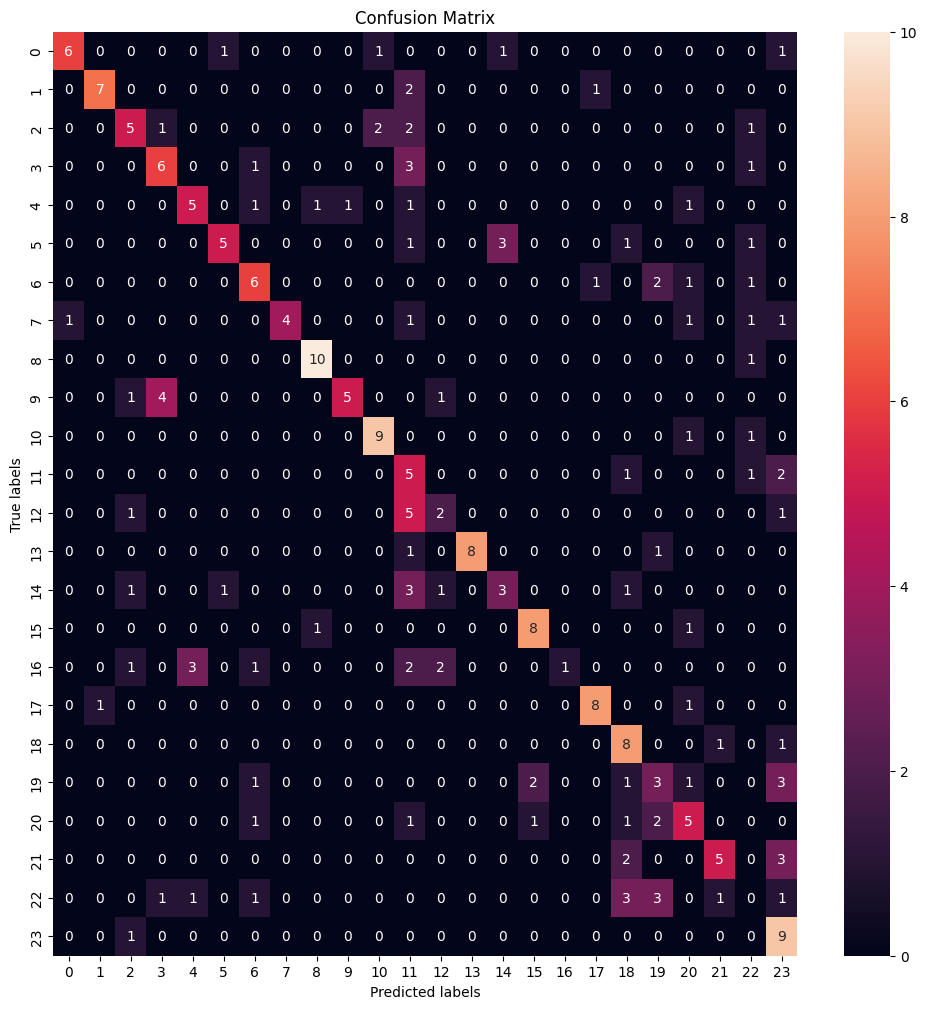

In [ ]:
test_y = torch.tensor(newDf['label_int'].tolist())

cm = confusion_matrix(test_y, preds)

plt.subplots(figsize=(12,12))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)  #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [ ]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.88      0.70      0.78        10
           2       0.50      0.45      0.48        11
           3       0.50      0.55      0.52        11
           4       0.56      0.50      0.53        10
           5       0.71      0.45      0.56        11
           6       0.50      0.55      0.52        11
           7       1.00      0.44      0.62         9
           8       0.83      0.91      0.87        11
           9       0.83      0.45      0.59        11
          10       0.75      0.82      0.78        11
          11       0.19      0.56      0.28         9
          12       0.33      0.22      0.27         9
          13       1.00      0.80      0.89        10
          14       0.43      0.30      0.35        10
          15       0.73      0.80      0.76        10
          16       1.00      0.10      0.18        10
          17       0.80    

#Decision Tree and SVM Model

In [ ]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
# For handling string
import string
import spacy
# For visualizations
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
stopwords = list(STOP_WORDS)

from heapq import nlargest
punctuation = punctuation + '\n'

Data set was already loaded  in the dataframe df


In [ ]:

#categorical encoding of labels
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
df["label_no"]=lb.fit_transform(df["label"])
df.head()


label                                               text  \
0  Psoriasis  experience skin rash arm leg torso past week r...   
1  Psoriasis  skin peel especially knee elbow scalp peeling ...   
2  Psoriasis  experience joint pain finger wrist knee pain a...   
3  Psoriasis  silver like dust skin especially low scalp dus...   
4  Psoriasis  nail small dent pit feel inflammatory tender t...   

                                       Original_text  label_no  
0  I have been experiencing a skin rash on my arm...        15  
1  My skin has been peeling, especially on my kne...        15  
2  I have been experiencing joint pain in my fing...        15  
3  There is a silver like dusting on my skin, esp...        15  
4  My nails have small dents or pits in them, and...        15

#Train test Splitting

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label_no"], test_size=0.2, random_state=42)



In [ ]:
vectorizer = TfidfVectorizer(max_features=1500)

X_train_v = vectorizer.fit_transform(X_train).toarray()
X_test_v = vectorizer.transform(X_test).toarray()

# Using Decision Tree Claasifier

In [ ]:
#creating model for the classification
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='gini', max_depth=24, random_state=0)
dtc.fit(X_train_v, y_train)

DecisionTreeClassifier(max_depth=24, random_state=0)

In [ ]:
y_pred = dtc.predict(X_test_v)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

def report(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.subplots(figsize=(12,12))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)  #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

Accuracy: 0.73
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.83      0.91         6
           2       0.82      0.90      0.86        10
           3       1.00      0.91      0.95        11
           4       0.33      0.38      0.35         8
           5       0.89      0.73      0.80        11
           6       0.44      0.36      0.40        11
           7       1.00      1.00      1.00         9
           8       1.00      0.75      0.86        12
           9       1.00      0.89      0.94         9
          10       1.00      0.82      0.90        11
          11       1.00      1.00      1.00         8
          12       1.00      0.86      0.92         7
          13       1.00      0.86      0.92         7
          14       0.90      0.82      0.86        11
          15       0.62      0.56      0.59         9
          16       0.78      0.70      0.74        10
          17

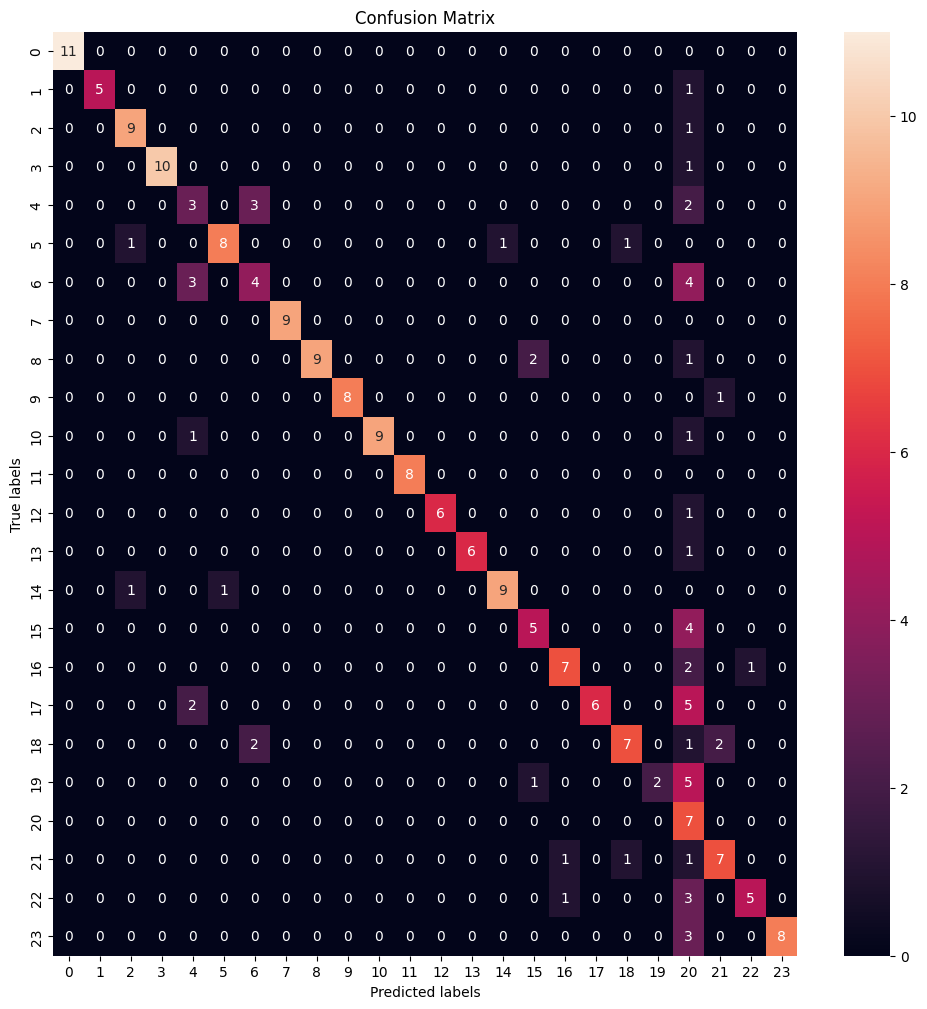

In [ ]:
report(y_test,y_pred)

In [ ]:
# getting prediction on random text
# modification has been done on the original text and getting the prediction after modification
sent1 = 'These fractures hurt and bleed frequently. The fractures are itchy and covered with scales. My fingers and soles have pretty thick skin that is cracked severely' # Psoriasis
sent2 = 'I am feeling sick. I have a fever and headache. I noticed rashes on my arms and face. I am worried about this. I observed red sores near my nose.' # Impetigo
sent3 = 'I have a rash on my legs that is causing discomforts. There is a cramp and I can see prominent veins on the calf. I have been feeling very tired and fatigued in the past couple of days.' # Varicose Veins

text = [sent1, sent2, sent3]

#preprocessign the text before testing
# Expanding Contractions in the reviews
text = list(map(lambda x: expand_contractions(x), text))

# change all text to lower case
text = list(map(lambda x: x.lower(), text))

# remove punctuations
text = list(map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x), text))

# Lemmatization with stopwords removal
text = list(map(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]), text))

newtest_v = vectorizer.transform(text).toarray()

y_pred = dtc.predict(newtest_v)


print(y_pred)
print(lb.inverse_transform(y_pred))


[20 10 17]
['drug reaction' 'Impetigo' 'Varicose Veins']


# Using SVM model

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear', C = 1).fit(X_train_v, y_train)
svm_pred = svm.predict(X_test_v)

Accuracy: 0.96
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        11
           4       0.57      1.00      0.73         8
           5       0.92      1.00      0.96        11
           6       0.88      0.64      0.74        11
           7       1.00      1.00      1.00         9
           8       1.00      1.00      1.00        12
           9       0.90      1.00      0.95         9
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00         8
          12       1.00      1.00      1.00         7
          13       1.00      1.00      1.00         7
          14       1.00      1.00      1.00        11
          15       1.00      0.89      0.94         9
          16       1.00      0.90      0.95        10
          17

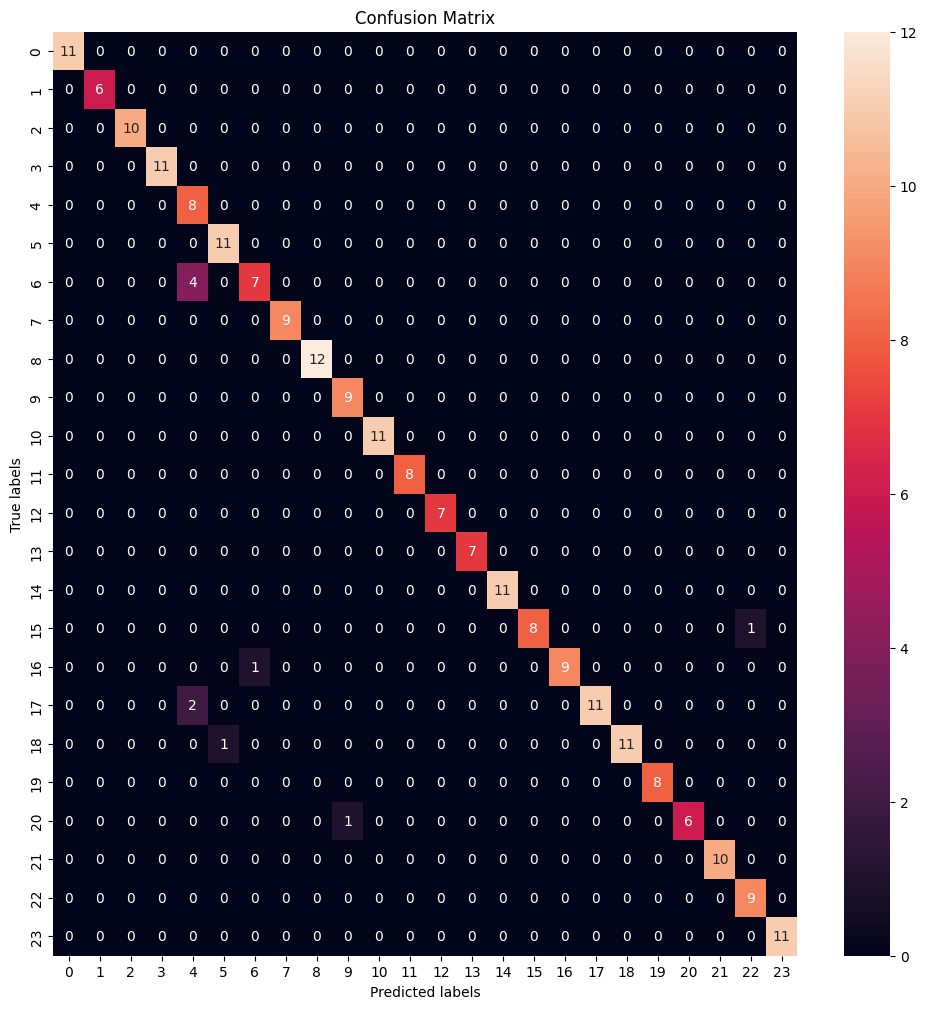

In [ ]:
report(y_test,svm_pred)

In [ ]:
# getting prediction on random text
# modification has been done on the original text and getting the prediction after modification
sent1 = 'These fractures hurt and bleed frequently. The fractures are itchy and covered with scales. My fingers and soles have pretty thick skin that is cracked severely' # Psoriasis
sent2 = 'I am feeling sick. I have a fever and headache. I noticed rashes on my arms and face. I am worried about this. I observed red sores near my nose.' # Impetigo
sent3 = 'I have a rash on my legs that is causing discomforts. There is a cramp and I can see prominent veins on the calf. I have been feeling very tired and fatigued in the past couple of days.' # Varicose Veins

text = [sent1, sent2, sent3]

#preprocessign the text before testing
# Expanding Contractions in the reviews
text = list(map(lambda x: expand_contractions(x), text))

# change all text to lower case
text = list(map(lambda x: x.lower(), text))

# remove punctuations
text = list(map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x), text))

# Lemmatization with stopwords removal
text = list(map(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]), text))

newtest_v = vectorizer.transform(text).toarray()

y_pred = svm.predict(newtest_v)


print(y_pred)
print(lb.inverse_transform(y_pred))


[15 10 17]
['Psoriasis' 'Impetigo' 'Varicose Veins']


# Use of summarized text as test data and predicting the result

In [ ]:
# Here we upload the summarized data which we get from summarization in another file (from fine tuning file)
newDf = pd.read_csv('/content/summary.csv')

In [ ]:
newDf.head()

Unnamed: 0      label  label_int  \
0           0  Psoriasis         15   
1           1  Psoriasis         15   
2           2  Psoriasis         15   
3           3  Psoriasis         15   
4           4  Psoriasis         15   

                                                text  \
0  experience skin rash arm leg torso past week r...   
1  skin palm sol thicken deep crack crack painful...   
2  experience fatigue general feeling malaise fee...   
3  start rash skin rash bleed scratch rub notice ...   
4  rash skin heal notice sudden peeling skin espe...   

                                       Original_text  \
0  I have been experiencing a skin rash on my arm...   
1  The skin on my palms and soles is thickened an...   
2  I have experienced fatigue and a general feeli...   
3  I am starting to have rashes on my skin. The r...   
4  The rashes on my skin are not healing. Moreove...   

                                    summary_original  
0  I have been experiencing a skin rash on my arm...  
1  I have noticed a sudden peeling of skin at dif...  
2  The rash on my skin is worse in the winter mon...  
3  Also, I have noticed strange peeling of skin i...  
4  Moreover, I have noticed a sudden peeling of t...

In [ ]:
newDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        247 non-null    int64 
 1   label             247 non-null    object
 2   label_int         247 non-null    int64 
 3   text              247 non-null    object
 4   Original_text     247 non-null    object
 5   summary_original  238 non-null    object
dtypes: int64(2), object(4)
memory usage: 11.7+ KB


In [ ]:
newDf.drop(['Unnamed: 0'],axis=1, inplace=True)
newDf.head()

label  label_int                                               text  \
0  Psoriasis         15  experience skin rash arm leg torso past week r...   
1  Psoriasis         15  skin palm sol thicken deep crack crack painful...   
2  Psoriasis         15  experience fatigue general feeling malaise fee...   
3  Psoriasis         15  start rash skin rash bleed scratch rub notice ...   
4  Psoriasis         15  rash skin heal notice sudden peeling skin espe...   

                                       Original_text  \
0  I have been experiencing a skin rash on my arm...   
1  The skin on my palms and soles is thickened an...   
2  I have experienced fatigue and a general feeli...   
3  I am starting to have rashes on my skin. The r...   
4  The rashes on my skin are not healing. Moreove...   

                                    summary_original  
0  I have been experiencing a skin rash on my arm...  
1  I have noticed a sudden peeling of skin at dif...  
2  The rash on my skin is worse in the winter mon...  
3  Also, I have noticed strange peeling of skin i...  
4  Moreover, I have noticed a sudden peeling of t...

In [ ]:
newDf["summary_original"] = newDf["summary_original"].apply(lambda x: str(x))

In [ ]:
# Expanding Contractions in the reviews
newDf['summary_original']=newDf['summary_original'].apply(lambda x:expand_contractions(x))

# change all text to lower case
newDf['summary_original']=newDf['summary_original'].apply(lambda x: x.lower())

# remove punctuations
newDf['summary_original']=newDf['summary_original'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

# Lemmatization with stopwords removal
newDf['summary_original']=newDf['summary_original'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

newDf.head()

label  label_int                                               text  \
0  Psoriasis         15  experience skin rash arm leg torso past week r...   
1  Psoriasis         15  skin palm sol thicken deep crack crack painful...   
2  Psoriasis         15  experience fatigue general feeling malaise fee...   
3  Psoriasis         15  start rash skin rash bleed scratch rub notice ...   
4  Psoriasis         15  rash skin heal notice sudden peeling skin espe...   

                                       Original_text  \
0  I have been experiencing a skin rash on my arm...   
1  The skin on my palms and soles is thickened an...   
2  I have experienced fatigue and a general feeli...   
3  I am starting to have rashes on my skin. The r...   
4  The rashes on my skin are not healing. Moreove...   

                                    summary_original  
0  experience skin rash arm leg torso past week s...  
1  notice sudden peeling skin different part body...  
2  rash skin bad winter month air dry rash skin s...  
3  notice strange peeling skin different part bod...  
4  notice sudden peeling skin especially skin elb...

In [ ]:
newDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   label             247 non-null    object
 1   label_int         247 non-null    int64 
 2   text              247 non-null    object
 3   Original_text     247 non-null    object
 4   summary_original  247 non-null    object
dtypes: int64(1), object(4)
memory usage: 9.8+ KB


In [ ]:
# actual values
print ("Actual values")
print (f"{newDf.iloc[1]['label']}, {newDf.iloc[10]['label']}, {newDf.iloc[75]['label']}, {newDf.iloc[11]['label']}, {newDf.iloc[49]['label']}, {newDf.iloc[105]['label']}")


Actual values
Psoriasis, Varicose Veins, Common Cold, Varicose Veins, Impetigo, Arthritis


In [ ]:
print ("Predicted values")
text = [newDf.iloc[1]['summary_original'], newDf.iloc[10]['summary_original'], newDf.iloc[75]['summary_original'], newDf.iloc[11]['summary_original'], newDf.iloc[49]['summary_original'], newDf.iloc[105]['summary_original']]

newtest_v = vectorizer.transform(text).toarray()


#using decision tree classifier model to predict
y_pred = dtc.predict(newtest_v)


print(y_pred)
print(lb.inverse_transform(y_pred))

Predicted values
[15 17  5 17 10  1]
['Psoriasis' 'Varicose Veins' 'Common Cold' 'Varicose Veins' 'Impetigo'
 'Arthritis']


In [ ]:
#predicting for all the summarized text through decision tree model

test_summarized_v = vectorizer.transform(newDf['summary_original']).toarray()

y_pred_dtc = dtc.predict(test_summarized_v)
print(y_pred_dtc)

y_test_dtc= newDf['label_int'].tolist()


[15 15 15 15 15 15 15 15 15 15 17 17 17 17 17 17 17 17 17 17 23 16 16 16
 16 16 23 23 16 16 20 20  8 20  4  4 20 20  4 20 20 10 10 10 10 10 10 10
 10 10 10 20  6  6 20 20  4  6  6  6  6  6 20  8  8  8 20  8  8  8  8  8
  8 20  5  5  5  5  5  5  2  5 18  5  5 14 14 14 14  5 14  5  5  5  7  7
  7  7  7 16 20  7 20  3  1  1  1  1  1  1 20  1 20 15  0  0  0 15  0  0
  0  0 15  5  2  2  2  2  2  2  2  5  2 20  9  9  9  9  9  9  9  9  9  9
  9 20 13 13 13 13 13 13 13 13 13 20 20 20  2  2  2  2  3  3  3  2 10 11
 10 11 11 11 11 23 20 12 20 20 20 12 12 20 20 20 23 23 23 20 20 23 20 23
 23 23 18 18 18  5 18 18 18 18 18 18 21 21 21 20 21 21 21 21 21 20  6 20
 20 15 20 19 20 20 20 19 20 20 22 22 21 22  5 22  5 22  5 16 19 19  2 15
 19 19  5 15 19 19 14]


Accuracy: 0.69
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.70      0.82        10
           2       0.53      0.73      0.62        11
           3       0.75      0.27      0.40        11
           4       0.75      0.30      0.43        10
           5       0.40      0.73      0.52        11
           6       0.88      0.64      0.74        11
           7       1.00      0.67      0.80         9
           8       0.90      0.82      0.86        11
           9       1.00      1.00      1.00        11
          10       0.83      0.91      0.87        11
          11       1.00      0.56      0.71         9
          12       1.00      0.33      0.50         9
          13       1.00      0.90      0.95        10
          14       0.83      0.50      0.62        10
          15       0.62      1.00      0.77        10
          16       0.78      0.70      0.74        10
          17

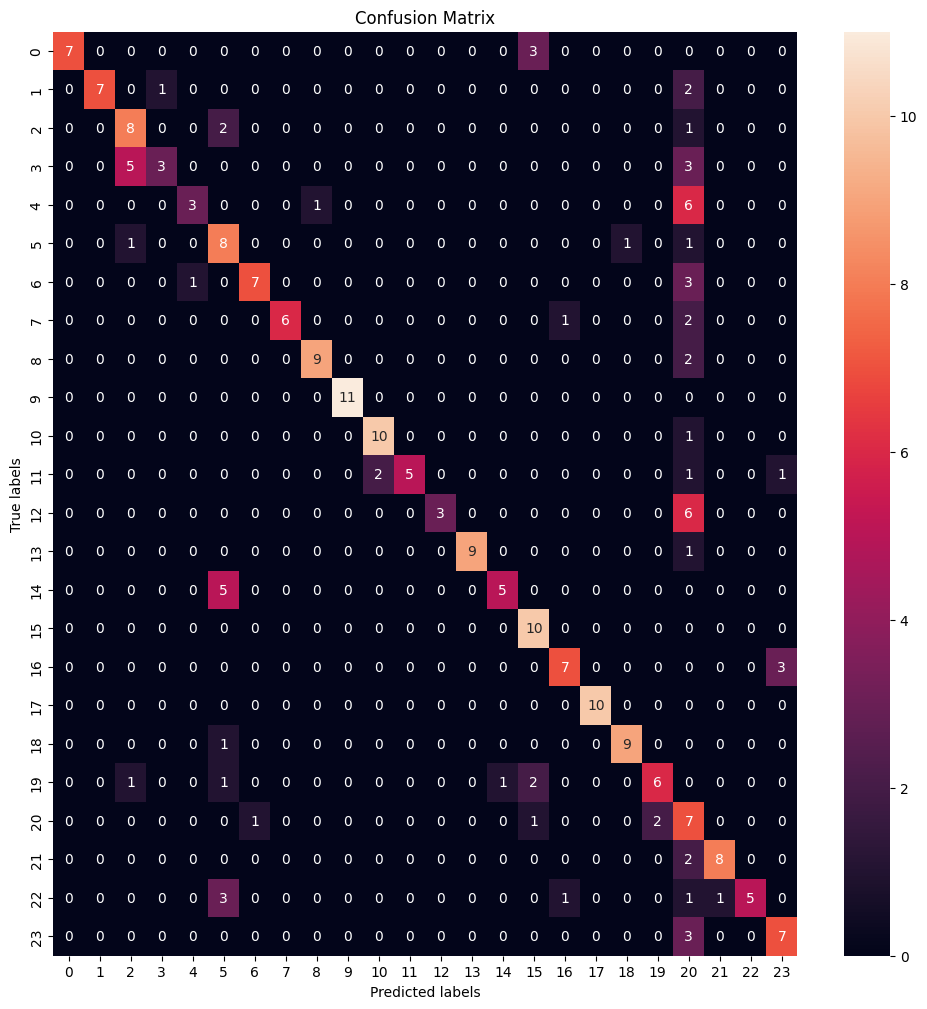

In [ ]:
report(y_test_dtc,y_pred_dtc)

Using SVM model for prediction of summarirized text

In [ ]:
y_pred_svm = svm.predict(test_summarized_v)
print(y_pred_svm)

y_test_svm= newDf['label_int'].tolist()


[15 15 15 15 15 15 15 15 15 15 17 17 17 17 17 17 17 17 17 17 16 16 16 16
 16 16 16 16 16 16  4  4  4  4  4  4  4  4  4  4 20 10 10 10 10 10 10 10
 10 10 10 20  6  6  6  6  6  6  6  6  6  6 20  8  8  8  8  8  8  8  8  8
  8 20  5  5  5  5  5 14  5  5  5  5 14 14 14 14 14 14 14 14 14 14  7  7
  7  7  7  7  7  7 20  1  1  1  1  1  1  1  1  1  1 15  0  0  0  0  0  0
  0  0 15  2  2  2  2  2  2  2  2  2  2 20  9  9  9  9  9  9  9  9  9  9
  9 20 13 13 13 13 13 13 13 13 13 20  3  3  3  3  3  3  3  3  3  3 11 11
 11 11 11 11 11 11 20 12 12 12 12 12 12 12 12 12 23 23 23 23 23 23 23 23
 23 23 18 18 18 18 18 18 18 18 18 18 21 21 21 21 21 21 21 21 21 21 20 20
 20 20 20 20 20 20 20 20 20 22 22 22 22 22 22 22 22 22 22 22 19 19 19 19
 19 19 19 19 19 19 19]


Accuracy: 0.95
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       1.00      1.00      1.00        10
           2       1.00      0.91      0.95        11
           3       1.00      0.91      0.95        11
           4       1.00      1.00      1.00        10
           5       1.00      0.82      0.90        11
           6       1.00      0.91      0.95        11
           7       1.00      0.89      0.94         9
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00        11
          10       1.00      0.91      0.95        11
          11       1.00      0.89      0.94         9
          12       1.00      1.00      1.00         9
          13       1.00      0.90      0.95        10
          14       0.91      1.00      0.95        10
          15       0.83      1.00      0.91        10
          16       1.00      1.00      1.00        10
          17

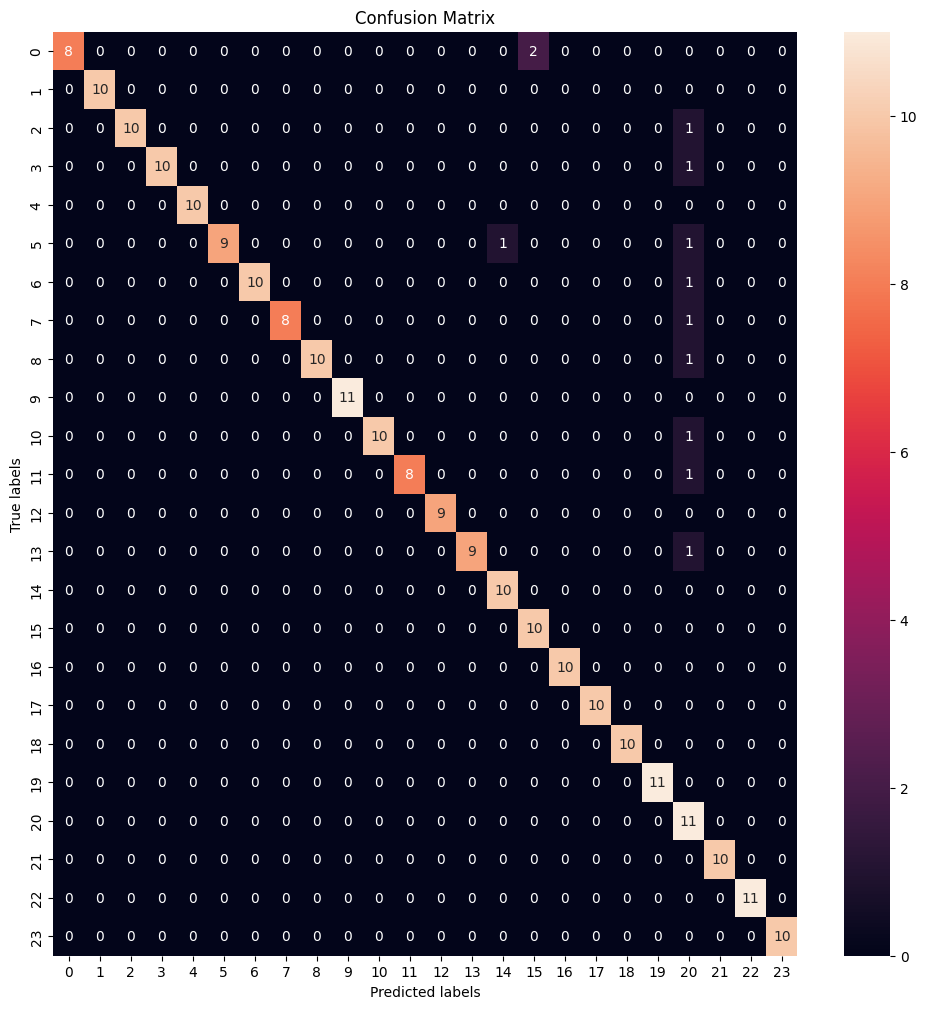

In [ ]:
report(y_test_svm,y_pred_svm)